# Generative AI Nanodegree Capstone: Personalised Real Estate Agent

## Importing Libraries & Declaring Settings

In [57]:
import os, requests, io, random, pickle, chromadb
import matplotlib.pyplot as plt
import numpy as np
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, NonNegativeInt
from typing import List, Optional
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel, CLIPTextConfig
from langchain.vectorstores import Chroma
from langchain.memory import ChatMessageHistory, ConversationBufferMemory
from langchain.chains import ConversationChain

os.environ["OPENAI_API_KEY"] = "voc-XXX"
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"

CLIP_MODEL_ID = "openai/clip-vit-base-patch32"

## Synthetic Data Generation

Initialising LLM

In [2]:
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=1.
)

### Generate Listings

#### Setting up parser

In [3]:
class RealEstateListing(BaseModel):
    neighborhood: str = Field(description='The neighborhood name of the property in string')
    price: int = Field(description='The price of the property in integers')
    bedrooms: int = Field(description='The number of bedrooms in the property in integers')
    bathrooms: int = Field(description='The number of bathrooms in the property in integers')
    size: float = Field(description='The area size of the property in float of square meters')
    description: str = Field(description='The description of the property in string')
    neighborhood_description: str = Field(description='The description of the neighborhood in string')
    image: Optional[bytes] = Field(description='The image of the property in bytes')
    text_embeddings: Optional[List[float]] = Field(description='The text embeddings of the property in list of floats')
    image_embeddings: Optional[List[float]] = Field(description='The image embeddings of the property in list of floats')

In [4]:
parser = PydanticOutputParser(pydantic_object=RealEstateListing)

In [5]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"neighborhood": {"title": "Neighborhood", "description": "The neighborhood name of the property in string", "type": "string"}, "price": {"title": "Price", "description": "The price of the property in integers", "type": "integer"}, "bedrooms": {"title": "Bedrooms", "description": "The number of bedrooms in the property in integers", "type": "integer"}, "bathrooms": {"title": "Bathrooms", "description": "The number of bathrooms in the property in integers", "type": "integer"}, "size": {"title": "Size", "description": "The area si

#### Setting up template

In [9]:
prompt = PromptTemplate(
    template='{question}\n{format_instructions}',
    input_variables=['question'],
    partial_variables={'format_instructions': parser.get_format_instructions},
)
question = """
Generate detailed informations of a real estate listing containing a made up neighborhood name, its price in poundsterling, the number of bedrooms, the number of bathrooms, its size in square meters, its description, its neighborhood description.
Do not fill in the image, text_embeddings, and image_embeddings attributes.
"""

query = prompt.format(question= question)
print(query)


Generate detailed informations of a real estate listing containing a made up neighborhood name, its price in poundsterling, the number of bedrooms, the number of bathrooms, its size in square meters, its description, its neighborhood description.
Do not fill in the image, text_embeddings, and image_embeddings attributes.

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"neighborhood": {"title": "Neighborhood", "description": "The neighborhood name of the property in string", "type": "string"}, "price": {"title": "Price", "description": "The price of the property in integers

#### Generate 10 Mock Listings

In [10]:
listings = list()

for i in tqdm(range(10)):
    output = llm.predict(query)
    res = parser.parse(output)
    listings.append(res)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.35s/it]


In [11]:
for i in listings:
    print(i, '\n')

neighborhood='Greenwood Grove' price=750000 bedrooms=4 bathrooms=3 size=250.5 description='This stunning 4-bedroom, 3-bathroom home in Greenwood Grove offers modern amenities and spacious living. With a large open-plan kitchen and living area, a private garden, and a two-car garage, this property is perfect for families. The master bedroom features an en-suite bathroom and a walk-in closet, while the other bedrooms are generously sized and share two well-appointed bathrooms. The home also includes a home office and a laundry room, both designed for convenience.' neighborhood_description='Greenwood Grove is a tranquil and picturesque neighborhood known for its lush greenery and friendly community. The area boasts excellent schools, numerous parks, and a variety of shops and restaurants. Residents can enjoy leisurely walks along tree-lined streets, and there are plenty of outdoor activities for everyone to enjoy. Greenwood Grove is also conveniently located near major roadways, making co

### Generating Real Estate Images

In [12]:
API_URL = "https://api-inference.huggingface.co/models/black-forest-labs/FLUX.1-dev"
headers = {"Authorization": "Bearer hf_XXXXXX"}

def image_query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
    
	return response.content

Generate 10 Images

In [13]:
house_images = list()

for listing in tqdm(listings):
    # Get property & neighborhood descriptions
    house_desc = listing.description
    neighborhood_desc = listing.neighborhood_description

    # Use descriptions to generate image
    prompt = f'{house_desc} '
    im_bytes = image_query({
        "inputs": prompt
    })

    house_images.append(Image.open(io.BytesIO(im_bytes)))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:03<00:00, 78.32s/it]


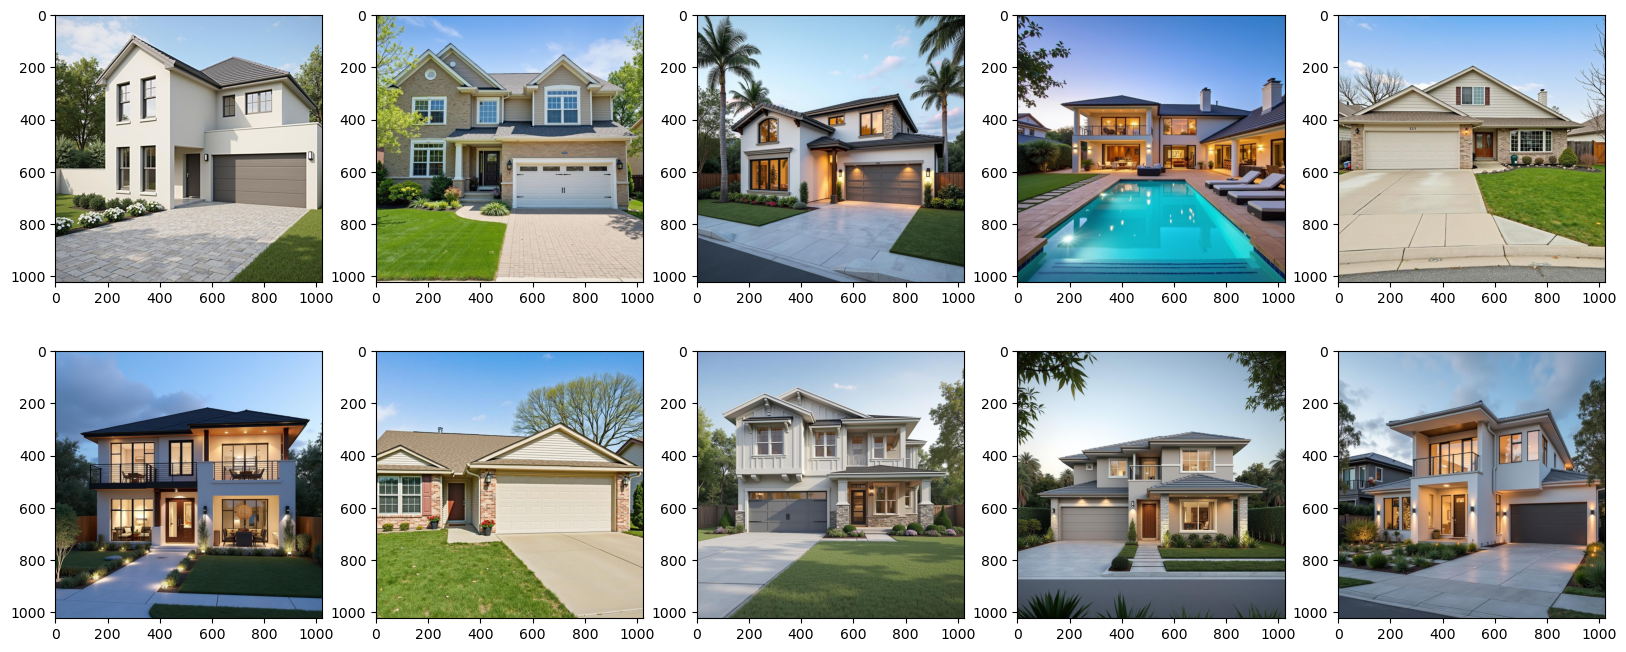

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for idx, im in enumerate(house_images):
    # save the image
    im.save(f'./img/img-{idx+1}.jpg', 'JPEG')

    # plot the image
    row = (idx) // 5
    col = (idx) % 5
    ax[row, col].imshow(im)

## Semantic Search

### Create Multimodal Embeddings

In [15]:
# Initialize CLIP processor and model
clip_model = CLIPModel.from_pretrained(CLIP_MODEL_ID)
clip_processor = CLIPProcessor.from_pretrained(CLIP_MODEL_ID)

/opt/homebrew/Caskroom/miniforge/base/envs/gen-real-estate/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
for idx, listing in enumerate(listings):
    # Save image as bytes
    img = house_images[idx] # the image modality
    buf = io.BytesIO()
    img.save(buf, format="JPEG")
    img_bytes = buf.getvalue()
    listing.image = img_bytes
    
    # Get embeddings
    listing_desc = f'{listing.description} {listing.neighborhood_description}' # the text modality
    processed_img = clip_processor(images=img, return_tensors='pt')
    processed_text = clip_processor(text=[listing_desc], return_tensors='pt', padding=True, truncation=True)
    img_embeddings = clip_model.get_image_features(**processed_img).detach().tolist()[0]
    text_embeddings = clip_model.get_text_features(**processed_text).detach().tolist()

    # Save embeddings
    listing.image_embeddings = img_embeddings
    listing.text_embeddings = text_embeddings[0]


In [29]:
len(listings[0].image_embeddings)

512

In [30]:
# Save listings
file = open('listings.pkl', 'wb')
pickle.dump(listings, file)
file.close()

In [77]:
# Load listings
file = open('listings.pkl', 'rb')
listings = pickle.load(file)
file.close()

### Creating Vector Database and Storing Listings

In [37]:
listing_docs = list()
listing_embeddings = list()
listing_ids = list()

# Generate lists of documents, embeddings, and IDs from the generated listings
for idx, listing in enumerate(listings):
    listing_doc = f"""
    Neighborhood: {listing.neighborhood}
    Price: £{listing.price:,}
    Bedrooms: {listing.bedrooms}
    Bathrooms: {listing.bathrooms}
    House size: {listing.size} sqm
    Description: {listing.description}
    Neighborhood Description: {listing.neighborhood_description}
    """
    
    # Average text & image embeddings together to get the overall embeddings
    listing_embeddings.append(np.mean([listing.image_embeddings, listing.text_embeddings], axis=0).tolist())
    listing_docs.append(listing_doc)
    listing_ids.append(f'listing_{idx+1}')

In [38]:
chroma_client = chromadb.Client()
coll = chroma_client.create_collection(name="listings", get_or_create=True)
coll.add(
    documents=listing_docs,
    embeddings=listing_embeddings,
    ids=listing_ids
)

In [39]:
# Storing listings
db = Chroma(client=chroma_client, collection_name="listings") 

### Building User Preference

In [40]:
questions = [   
    "How big do you want your house to be?" 
    "What are 3 most important things for you in choosing this property?", 
    "Which amenities would you like?", 
    "Which transportation options are important to you?",
    "How urban do you want your neighborhood to be?",   
]
answers = [
    "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
    "A quiet neighborhood, good local schools, and convenient shopping options.",
    "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
    "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
    "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
]

In [43]:
# Create user preference embeddings
preference_query = ' '.join(answers)
print(preference_query)

A comfortable three-bedroom house with a spacious kitchen and a cozy living room. A quiet neighborhood, good local schools, and convenient shopping options. A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system. Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads. A balance between suburban tranquility and access to urban amenities like restaurants and theaters.


### Searching DB Based on Preference

#### Text-Based Search

In [48]:
# Get query embeddings
processed_pref_q = clip_processor(text=[preference_query], return_tensors='pt', padding=True, truncation=True)
pref_q_embeddings = clip_model.get_text_features(**processed_pref_q).detach().tolist()

# Get 5 most similar listings
res = db.similarity_search_by_vector(pref_q_embeddings, k=5)
for r in res:
    print(r.page_content)


    Neighborhood: Brookview Meadows
    Price: £475,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 150.75 sqm
    Description: This charming 4-bedroom, 3-bathroom house located in the serene neighborhood of Brookview Meadows is an ideal family home. With an expansive living area, modern kitchen, and a beautiful backyard, this property offers both comfort and style. Additional features include a two-car garage, a spacious basement, and high ceilings throughout.
    Neighborhood Description: Brookview Meadows is a friendly and tranquil neighborhood, perfect for families and professionals alike. It boasts well-maintained parks, excellent schools, and a strong sense of community. Residents enjoy easy access to local shops, eateries, and recreational facilities, making it a convenient and desirable place to live.
    

    Neighborhood: Green Meadows
    Price: £550,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 250.75 sqm
    Description: Spacious and beautifully designed 4-be

#### Image-Based Search (NOT AUGMENTED)

In [73]:
# Get image based on user preference
im_bytes = image_query({
    "inputs": preference_query
})

ex_im_search = Image.open(io.BytesIO(im_bytes))

In [74]:
ex_im_search.save(f'./img-search.jpg', 'JPEG')

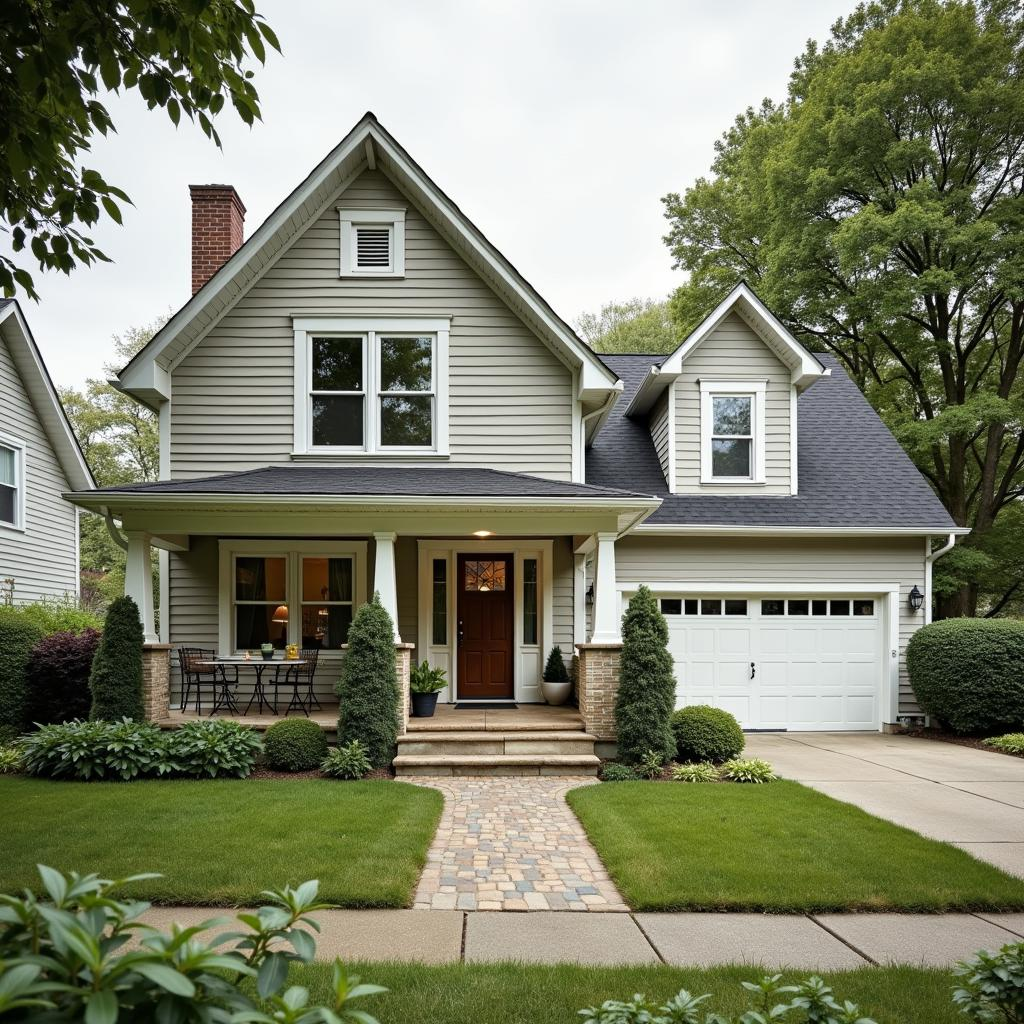

In [75]:
ex_im_search

In [76]:
# Get query image embeddings
processed_img = clip_processor(images=ex_im_search, return_tensors='pt')
img_embeddings = clip_model.get_image_features(**processed_img).detach().tolist()[0]

# Get 5 most similar listings
im_res = db.similarity_search_by_vector(img_embeddings, k=5)
for r in im_res:
    print(r.page_content)


    Neighborhood: Greenwood Estates
    Price: £450,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 120.5 sqm
    Description: This stunning 4-bedroom house in Greenwood Estates offers a spacious living room, modern kitchen, and cozy backyard. The master bedroom includes an en-suite bathroom with contemporary fixtures. High ceilings and large windows throughout offer plenty of natural light.
    Neighborhood Description: Greenwood Estates is a charming, family-friendly neighborhood known for its excellent schools, lush parks, and vibrant community events. Residents enjoy easy access to local restaurants, shops, and public transport, making it a desirable location for families and professionals alike.
    

    Neighborhood: Greenfield Estates
    Price: £450,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 150.0 sqm
    Description: This stunning 4-bedroom, 3-bathroom family home located in Greenfield Estates offers a perfect blend of modern amenities and classic charm. The p

## Augmented Response Generation

In [59]:
# Save preset user preference in a memory
history = ChatMessageHistory()
history.add_user_message("You are an AI that will personalize real estate listing and its neighborhood descriptions based on user preference. Probe users to obtain their preference first.")

for i in range(len(questions)):
    history.add_ai_message(questions[i])
    history.add_user_message(answers[i])

history.add_ai_message("Now give me the real estate listings that you would like to be personalized.")

Building conversation chain

In [60]:
# Create conversational buffer
conversational_memory = ConversationBufferMemory(
    chat_memory=history,
    memory_key="questions_and_answers", 
    input_key="input"
)

In [62]:
# Create personalizer
PERSONALIZER_TEMPLATE = """The following is a friendly conversation between a human and an AI Real Estate Listing Personalizer. 
The AI follows human instructions and provides personalized real estate listing and its neighborhood descriptions. 

Personal Questions and Answers:
{questions_and_answers}
Human: {input}
AI:"""

PROMPT = PromptTemplate(
    input_variables=["input", "questions_and_answers"],
    template=PERSONALIZER_TEMPLATE
)
personalizer = ConversationChain(llm=llm, verbose=True, memory=conversational_memory, prompt=PROMPT)

In [68]:
# Generate personalized listing with augmented context
listing_context = '\n\n'.join([str(i+1) + '. ' + res[i].page_content for i in range(len(res))]) # Formatting the top K listings
personalization_instruction = f"""
=== Real Estate Listings Context ===
{listing_context}
======
OUTPUT FORMAT: Follow the format under the Real Estate Listings Context and personalize the Description and Neighborhood Description attributes.
"""

personalized_listings = personalizer.predict(input=personalization_instruction) # getting the personalized listings



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI Real Estate Listing Personalizer. 
The AI follows human instructions and provides personalized real estate listing and its neighborhood descriptions. 

Personal Questions and Answers:
Human: You are an AI that will personalize real estate listing and its neighborhood descriptions based on user preference. Probe users to obtain their preference first.
AI: How big do you want your house to be?What are 3 most important things for you in choosing this property?
Human: A comfortable three-bedroom house with a spacious kitchen and a cozy living room.
AI: Which amenities would you like?
Human: A quiet neighborhood, good local schools, and convenient shopping options.
AI: Which transportation options are important to you?
Human: A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.
AI: How urban do you want your neighborhoo

In [70]:
print(personalized_listings)

Let me go ahead and personalize these real estate listings for your preferences.

=== Personalized Real Estate Listings ===

1. 
    Neighborhood: Brookview Meadows
    Price: £475,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 150.75 sqm
    Description: This charming 4-bedroom, 3-bathroom house located in the serene neighborhood of Brookview Meadows is an ideal family home. With an expansive living area and a modern, energy-efficient kitchen, it’s perfect for a comfortable living. The cozy living room is a great spot for relaxing evenings, and the beautiful backyard is ideal for gardening enthusiasts. Additional features include a two-car garage, a spacious basement, and high ceilings throughout, making this home both practical and stylish.
    Neighborhood Description: Brookview Meadows is a friendly and tranquil neighborhood, perfect for families and professionals alike. It boasts well-maintained parks and excellent schools, ensuring your children will receive a high-quality 

In [72]:
print(listing_context)

1. 
    Neighborhood: Brookview Meadows
    Price: £475,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 150.75 sqm
    Description: This charming 4-bedroom, 3-bathroom house located in the serene neighborhood of Brookview Meadows is an ideal family home. With an expansive living area, modern kitchen, and a beautiful backyard, this property offers both comfort and style. Additional features include a two-car garage, a spacious basement, and high ceilings throughout.
    Neighborhood Description: Brookview Meadows is a friendly and tranquil neighborhood, perfect for families and professionals alike. It boasts well-maintained parks, excellent schools, and a strong sense of community. Residents enjoy easy access to local shops, eateries, and recreational facilities, making it a convenient and desirable place to live.
    

2. 
    Neighborhood: Green Meadows
    Price: £550,000
    Bedrooms: 4
    Bathrooms: 3
    House size: 250.75 sqm
    Description: Spacious and beautifully design